<a href="https://colab.research.google.com/github/lollipopenator/Manning/blob/master/Pose_Estimation_1_Getting_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful resources

Getting data into colab notebooks
https://colab.research.google.com/notebooks/io.ipynb

Opening & viewing images from the SVHN dataset using python https://stackoverflow.com/questions/29185493/read-svhn-dataset-in-python

Notes on using 'numpy.where'
https://note.nkmk.me/en/python-numpy-where/


Online JSON editor
https://jsoneditoronline.org/#/


Adding forms to colab notebooks 
https://www.tutorialspoint.com/google_colab/google_colab_adding_forms.htm
https://colab.research.google.com/notebooks/forms.ipynb

# SVHN Dataset

## Retrieve data



### First method - upload the files from my local system

In [2]:
from google.colab import files

uploaded = files.upload()



Saving test_32x32.mat to test_32x32.mat


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "test_32x32.mat" with length 64275384 bytes


###  Second method - mount google drive

In [0]:
##################### Mount my Google drive (after having placed the files there)
#
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

## Display images

### Read images and labels into variables

In [0]:
# update scipy
!pip install -U -q scipy


In [0]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
############### Read data from matlab file 
test_data = scipy.io.loadmat('/content/test_32x32.mat')
# training_data = scipy.io.loadmat('/content/train_32x32.mat')

############### Extract images and labels from matlab file
test_images = test_data['X']
test_labels = test_data['y']
# training_images = training_data['X']
# training_labels = training_data['y']

In [0]:
############### Replace all '10' labels with '0'
test_labels = np.where(test_labels == 10, 0, test_labels)
# training_labels = np.where(training_labels == 10, 0, training_labels)

### Fix data labels

Digit Label: 3


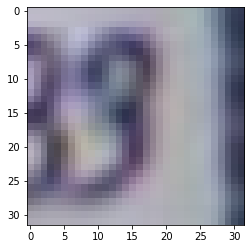

In [56]:

# Check image_id = 3 to see an example where the Digit Label is now '0'
# image_id = 3

image_id = 10 #@param {type:"slider", min:0, max:30, step:1}


print("Digit Label:", test_labels[image_id][0])

plt.imshow(test_images[:,:,:,image_id])
plt.show()



# COCO dataset

## Retrieve data

In [57]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess

# wsl - see notes for this section of course: 
# trainval2107.zip is large (~20GB) and only needed in part 4, not in parts 1 
# and 3 of project.

# files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']
files = ['val2017.zip', 'annotations_trainval2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


## Rearrange data



In [58]:

import json
from PIL import Image 
import matplotlib.pyplot as plt 


############ Get the right data and wrangle into useful form
with open('/content/annotations/person_keypoints_val2017.json') as json_file:
  json_data = json.load(json_file)


# Just pick first one for now...
selected_annotation = json_data["annotations"][0] 


# From the selected annotation, we can get most of what we need:
# i)   path to image, 
# ii)  the  bounding box we are going to use, and 
# iii) the list of keypoint coordinates/visibility data
image_path = "/content/val2017/%012d.jpg" % (selected_annotation["image_id"])
bounding_box = selected_annotation["bbox"]
keypoints_list = selected_annotation["keypoints"]

# We need to go to another part of the json file to get the names for the
# bodyparts with which the keypoints are associated
keypoints__bodypart_names = json_data["categories"][0]["keypoints"]


# Rearrange all of this keypoint data into a form easy to use later.

# In the data file, the positions and visibilities for the 17 labelled
# keypoints are stored as follows:
#
# [x0,y0,v0,x1,y1,v1,…x16,y16,v16]
#
# First pull out the [x, y, v] values for each keypoint into separate lists 
# of three. Then combine the bodypart names and the coordinates so that
# all keypoint info will now be in a dictionary
# with entries arranged as follows:
# 
# {
#  'nose': [0, 0, 0], 
#  'left_eye': [0, 0, 0], 
#  ...
#  ...
#  'left_hip': [92, 452, 2]
# }

kp__coords = [keypoints_list[i:i + 3] for i in range(0, len(keypoints_list), 3)]
kp__all_info = {k:v for k,v in zip(keypoints__bodypart_names, kp__coords)}

print(kp__all_info)




{'nose': [0, 0, 0], 'left_eye': [0, 0, 0], 'right_eye': [0, 0, 0], 'left_ear': [0, 0, 0], 'right_ear': [0, 0, 0], 'left_shoulder': [142, 309, 1], 'right_shoulder': [177, 320, 2], 'left_elbow': [191, 398, 2], 'right_elbow': [237, 317, 2], 'left_wrist': [233, 426, 2], 'right_wrist': [306, 233, 2], 'left_hip': [92, 452, 2], 'right_hip': [123, 468, 2], 'left_knee': [0, 0, 0], 'right_knee': [251, 469, 2], 'left_ankle': [0, 0, 0], 'right_ankle': [162, 551, 2]}


## Rescale image, overlay keypoints, and display image

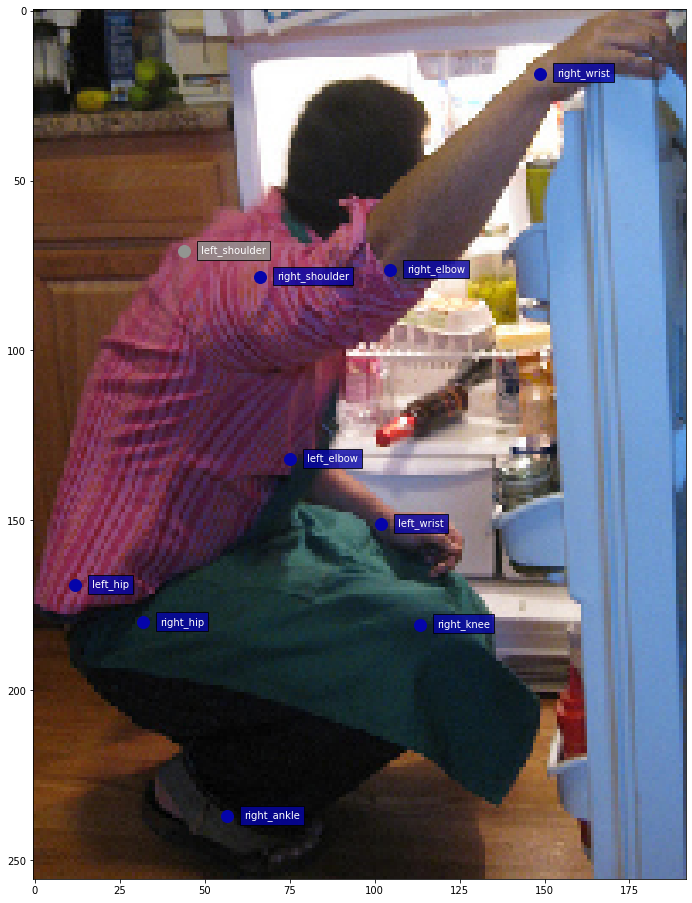

In [59]:
############### Create figure and axis 

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(label = "Scaled image with keypoints overlaid") 


############### Rescale, and display image
x = bounding_box[0]
y = bounding_box[1]
width_old = bounding_box[2]
height_old = bounding_box[3]

area_to_be_displayed = (x, y, x + width_old, y + height_old)

width_new = 192
height_new= 256

img = Image.open(image_path)
scaled_image = img.resize((width_new, height_new), box=area_to_be_displayed)


############### Add scaled keypoint markers and labels to the figure
for bodypart in kp__all_info:
    # visible keypoints have v > 0. v=1 means keypoint is in the image
    # but is occluded, v=2 means keypoint is fully visible
    if kp__all_info[bodypart][2] > 0:

      new_x =  (width_new/width_old) * (kp__all_info[bodypart][0]-x)
      new_y =  (height_new/height_old) * (kp__all_info[bodypart][1]-y)

      # color the fully-visible keypoints a brighter color
      label_color = 'xkcd:royal blue'

      # color the occluded keypoints grey
      if kp__all_info[bodypart][2] == 1:
        label_color = 'xkcd:grey'
     

      ax.text(new_x+5, new_y+0.5, bodypart, fontsize=10,  color='w',
              bbox=dict(facecolor=label_color, alpha=0.8))
      ax.scatter(new_x, new_y, s=144, c=label_color)

############### Display scaled image on the figure along with keypoint labels
ax.imshow(scaled_image)
